In [90]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5


In [91]:
# Plot Functions
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [101]:
# Basic EDA
train_data = pd.read_csv('train.csv')

# Labels
train_labels = train_data.loc[:,'SalePrice']

# Dummify for now
original_data = train_data.copy()
train_data = pd.get_dummies(train_data)

# Data
split = 200
train_data = train_data.drop('SalePrice', axis = 1)

# Split train data and dev Data
dev_data = train_data[:split]
train_data = train_data[split:]
dev_labels = train_labels[:split]
train_labels = train_labels[split:]

# Test data
test_data = pd.read_csv('test.csv')

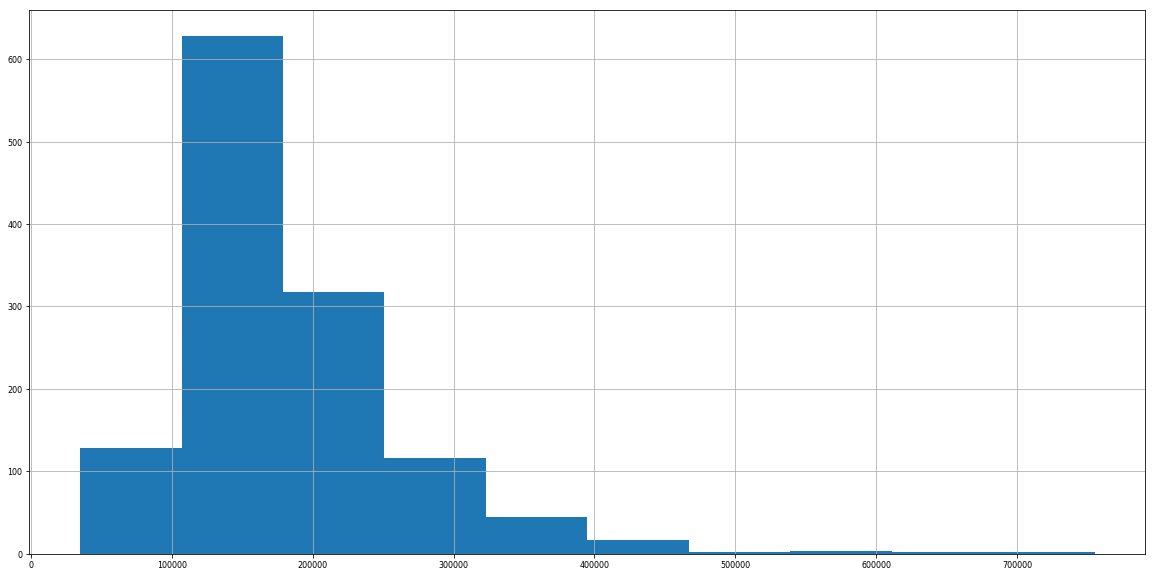

In [94]:
plt.figure(figsize=(20,10))
train_labels.hist()

In [95]:
# Basic Descriptions on all variables

# Numeric 
train_data.describe(include=[np.number]).transpose()


,count,mean,std,min,25%,50%,75%,max
Id,1260.0,830.500000,363.874979,201.0,515.75,830.5,1145.25,1460.0
MSSubClass,1260.0,57.416667,42.325812,20.0,20.00,50.0,70.00,190.0
LotFrontage,1037.0,69.722276,24.490523,21.0,59.00,69.0,80.00,313.0
LotArea,1260.0,10573.830159,10564.861206,1300.0,7553.50,9444.5,11601.50,215245.0
OverallQual,1260.0,6.099206,1.385446,1.0,5.00,6.0,7.00,10.0
OverallCond,1260.0,5.579365,1.126990,1.0,5.00,5.0,6.00,9.0
YearBuilt,1260.0,1971.332540,30.231167,1872.0,1954.00,1973.0,2000.25,2010.0
YearRemodAdd,1260.0,1984.879365,20.698710,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1252.0,100.244409,175.429065,0.0,0.00,0.0,160.00,1600.0
BsmtFinSF1,1260.0,442.176190,456.619993,0.0,0.00,381.0,709.00,5644.0


Lots of continuous variables and categorical ones - and not a lot of data (1460). Will probably not be a linear combination of features - probably some kind of tree-based model?

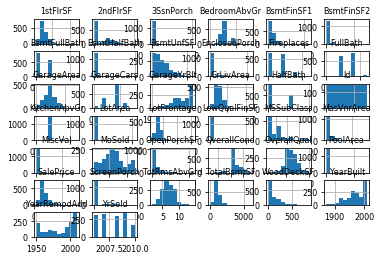

In [108]:
trainhist = original_data.hist()
plt.savefig('./numeric_EDA.pdf')

In [106]:
# Categorical
original_data.select_dtypes(include='object').apply(lambda x: x.value_counts()).T.stack()


MSZoning       C (all)      10.0
               FV           65.0
               RH           16.0
               RL         1151.0
               RM          218.0
Street         Grvl          6.0
               Pave       1454.0
Alley          Grvl         50.0
               Pave         41.0
LotShape       IR1         484.0
               IR2          41.0
               IR3          10.0
               Reg         925.0
LandContour    Bnk          63.0
               HLS          50.0
               Low          36.0
               Lvl        1311.0
Utilities      AllPub     1459.0
               NoSeWa        1.0
LotConfig      Corner      263.0
               CulDSac      94.0
               FR2          47.0
               FR3           4.0
               Inside     1052.0
LandSlope      Gtl        1382.0
               Mod          65.0
               Sev          13.0
Neighborhood   Blmngtn      17.0
               Blueste       2.0
               BrDale       16.0
          

Generally most of the value appear to be OK - not many missing values, but the categories can be fairly unbalanced in some cases (e.g. most "Sale Condition" is normal). 

Missing values look ok - some easy candidates to remove from our feature set. 

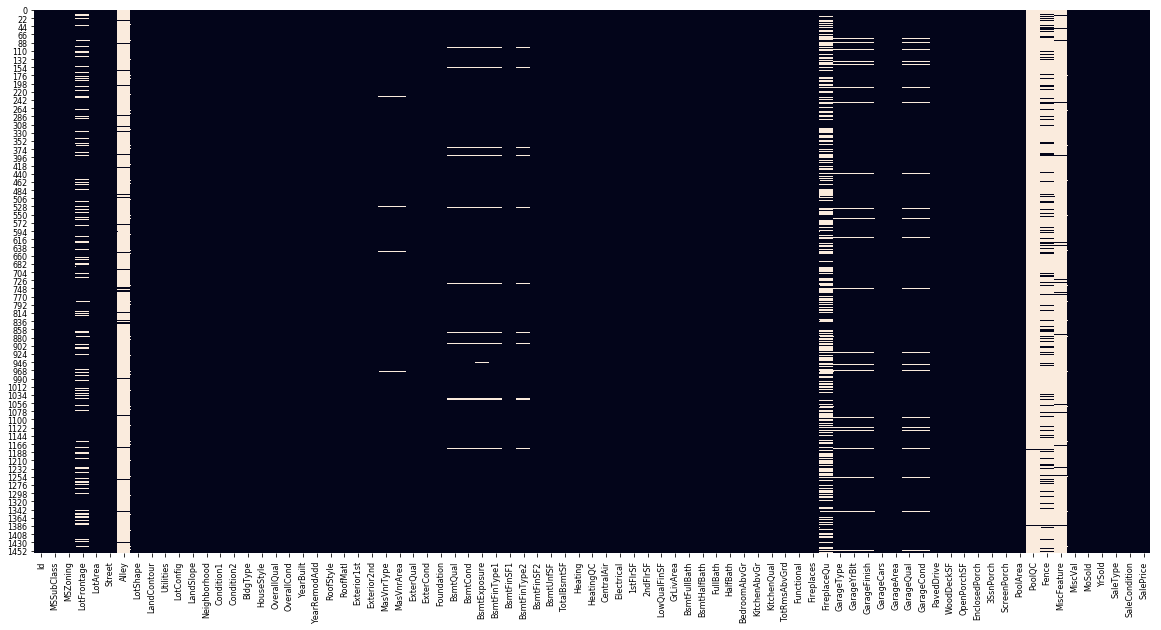

In [109]:
# Missing Values
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
plt.savefig('./missing_EDA.pdf')

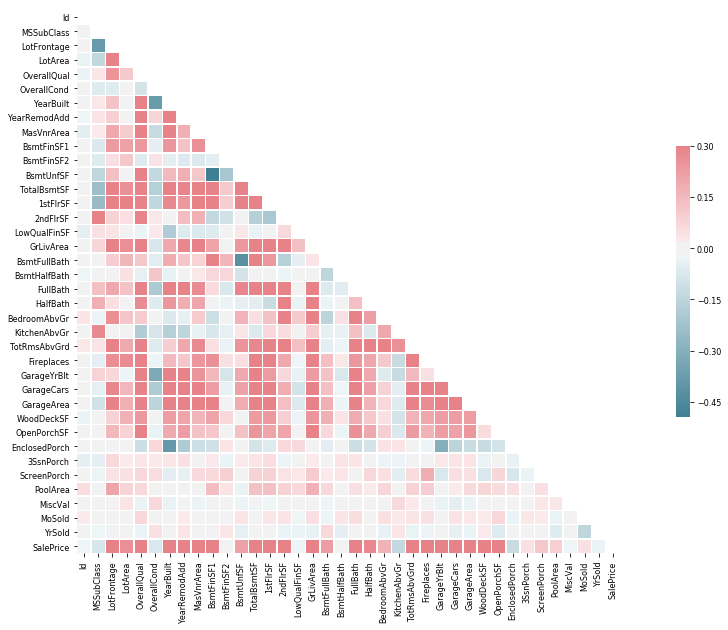

In [116]:
# Correlation matrix
plt.figure(figsize=(20,10))
corr = original_data.select_dtypes(exclude='object').corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [100]:
linearmodel = LinearRegression()
linearmodel.fit(train_data.fillna(0), train_labels)
dev_pred = linearmodel.predict(dev_data.fillna(0))

# Mean Abs % Error
print(np.mean(np.abs(dev_pred-dev_labels)/dev_labels))

# RMSLE
rmsle(dev_labels, dev_pred)

0.1123379574911979


0.19186040746590072